In [1]:
import sys
sys.path.append("../../")

# GaussianProcess

In [2]:
from neuralprocesses.utils.gp import GaussianProcess
from neuralprocesses.utils.gp import squared_exponential_kernel

import tensorflow as tf

## Basic example

Choose the x-coordinates.

In [3]:
x_target = tf.constant([list(range(50))], dtype=tf.float32)
queries = (None, x_target)

Setup a Gaussian process with a squared-exponential kernel of correlation length 10.

In [4]:
gp = GaussianProcess(queries, lambda x: squared_exponential_kernel(x, 10.))

Compute a sample of y-values and stack them with the x-values.

In [5]:
with tf.variable_scope("f"):
    f = tf.transpose(tf.reshape(tf.stack([gp.coordinates, gp.sample]), (2, -1)))

Run this Tensorflow graph and print the first few rows of the result.

In [6]:
with tf.Session() as session:
    result = session.run(f)

print(result[:5, :])

[[ 0.         -0.49628335]
 [ 1.         -0.3295097 ]
 [ 2.         -0.1406706 ]
 [ 3.          0.02143124]
 [ 4.          0.20234454]]


Plot the function that we just sampled from the GP.

In [7]:
from neuralprocesses.utils.plotting import list_plot

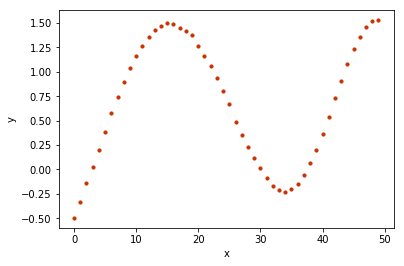

In [8]:
list_plot(result, axes_label=("x", "y"))

In [9]:
tf.reset_default_graph()

## Conditioned GP

Choose the x-coordinates.

In [10]:
x_context = tf.constant([[13, 39]], dtype=tf.float32)
y_context = tf.constant([[3., 0.5]], dtype=tf.float32)
x_target = tf.constant([list(range(50))], dtype=tf.float32)

queries = ((x_context, y_context), x_target)

Setup a Gaussian process with a squared-exponential kernel of correlation length 10.

In [11]:
gp = GaussianProcess(queries, lambda x: squared_exponential_kernel(x, 10.))

Compute a sample of y-values and stack them with the x-values (`f`). Then do the same with the mean values (`f0`) and confidence interval bounds (`fm` and `fp`).

In [12]:
from neuralprocesses.utils.tf_utils import tf_sort_by_col

In [13]:
with tf.variable_scope("f"):
    f = tf_sort_by_col(tf.transpose(tf.reshape(tf.stack([gp.coordinates, gp.sample]), (2, -1))), 0)
    fp = tf_sort_by_col(tf.transpose(tf.reshape(tf.stack([gp.coordinates, gp.mean + gp.standard_deviation]), (2, -1))), 0)
    fm = tf_sort_by_col(tf.transpose(tf.reshape(tf.stack([gp.coordinates, gp.mean - gp.standard_deviation]), (2, -1))), 0)
    f0 = tf_sort_by_col(tf.transpose(tf.reshape(tf.stack([gp.coordinates, gp.mean]), (2, -1))), 0)

Run this Tensorflow graph and print the first few rows of the result.

In [14]:
with tf.Session() as session:
    s, sp, sm, s0 = session.run([f, fp, fm, f0])

Plot the function that we just sampled from the GP.

In [15]:
from neuralprocesses.utils.plotting import list_plot
from neuralprocesses.utils.plotting import Color

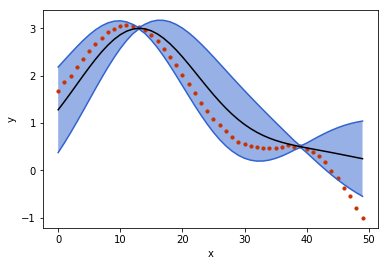

In [16]:
list_plot([s, sp, sm, s0],
          joined=[False,True,True,True], 
          mesh=[True,False,False,False],
          plot_style=[
              Color.color_data(n=0),      # Sample in red
              Color.color_data(n=1),      # Confidence interval bounds in blue
              Color.color_data(n=1),
              Color((0., 0., 0.))],       # Mean in black
          axes_label=("x", "y"),
          filling=[[1,2]]
    )

In [17]:
tf.reset_default_graph()